In [1]:
import numpy as np
import stim

# function to get the i'th bit of an integer n
def get_bit(n, i):
    return (n >> i) & 1

In [2]:
QRM_X_CHECKS = [
    [1,3,5,7,9,11,13,15],
    [2,3,6,7,10,11,14,15],
    [4,5,6,7,12,13,14,15],
    [8,9,10,11,12,13,14,15]
]

QRM_Z_CHECKS = [
    [ 1, 3, 5, 7, 0, 0],
    [ 3, 2, 7, 6, 0, 0],
    [ 2, 6,14,10, 0, 0],
    [ 6,14,12, 4, 0, 0],
    [13,12, 4, 5, 0, 0],
    [12, 8, 0,13, 9, 0],
    [ 8, 9,10,11, 0, 0],
    [ 9, 1,11, 3, 0, 0],
    [ 5, 7,13,15, 0, 0],
    [10,11,15,14, 0, 0],
    # redundancies
    [ 4, 5, 0, 0, 7, 6],
    [14, 0, 8, 0,10,12],
    [ 0, 0, 9, 1, 5,13],
    [ 0,10, 2, 0,11, 3],
    [ 0,15, 6, 0,14, 7],
    [15,13, 0, 0,12,14],
    [ 7, 0, 3, 0,15,11],
    [11, 0, 0, 9,13,15]
]

QRM_META_CHECKS = [
    [ 1,18, 8, 9],
    [ 1,18,13,17],
    [ 2,10,14,15],
    [ 2,10, 3,17],
    [ 5,15, 4, 9],
    [ 5,15,11,16],
    [ 7,16, 6,10],
    [ 7,16,12,18],
]

for sublist in QRM_Z_CHECKS:
    binary_sublist = [bin(x)[2:].zfill(4) for x in sublist]
    print(binary_sublist)

['0001', '0011', '0101', '0111', '0000', '0000']
['0011', '0010', '0111', '0110', '0000', '0000']
['0010', '0110', '1110', '1010', '0000', '0000']
['0110', '1110', '1100', '0100', '0000', '0000']
['1101', '1100', '0100', '0101', '0000', '0000']
['1100', '1000', '0000', '1101', '1001', '0000']
['1000', '1001', '1010', '1011', '0000', '0000']
['1001', '0001', '1011', '0011', '0000', '0000']
['0101', '0111', '1101', '1111', '0000', '0000']
['1010', '1011', '1111', '1110', '0000', '0000']
['0100', '0101', '0000', '0000', '0111', '0110']
['1110', '0000', '1000', '0000', '1010', '1100']
['0000', '0000', '1001', '0001', '0101', '1101']
['0000', '1010', '0010', '0000', '1011', '0011']
['0000', '1111', '0110', '0000', '1110', '0111']
['1111', '1101', '0000', '0000', '1100', '1110']
['0111', '0000', '0011', '0000', '1111', '1011']
['1011', '0000', '0000', '1001', '1101', '1111']


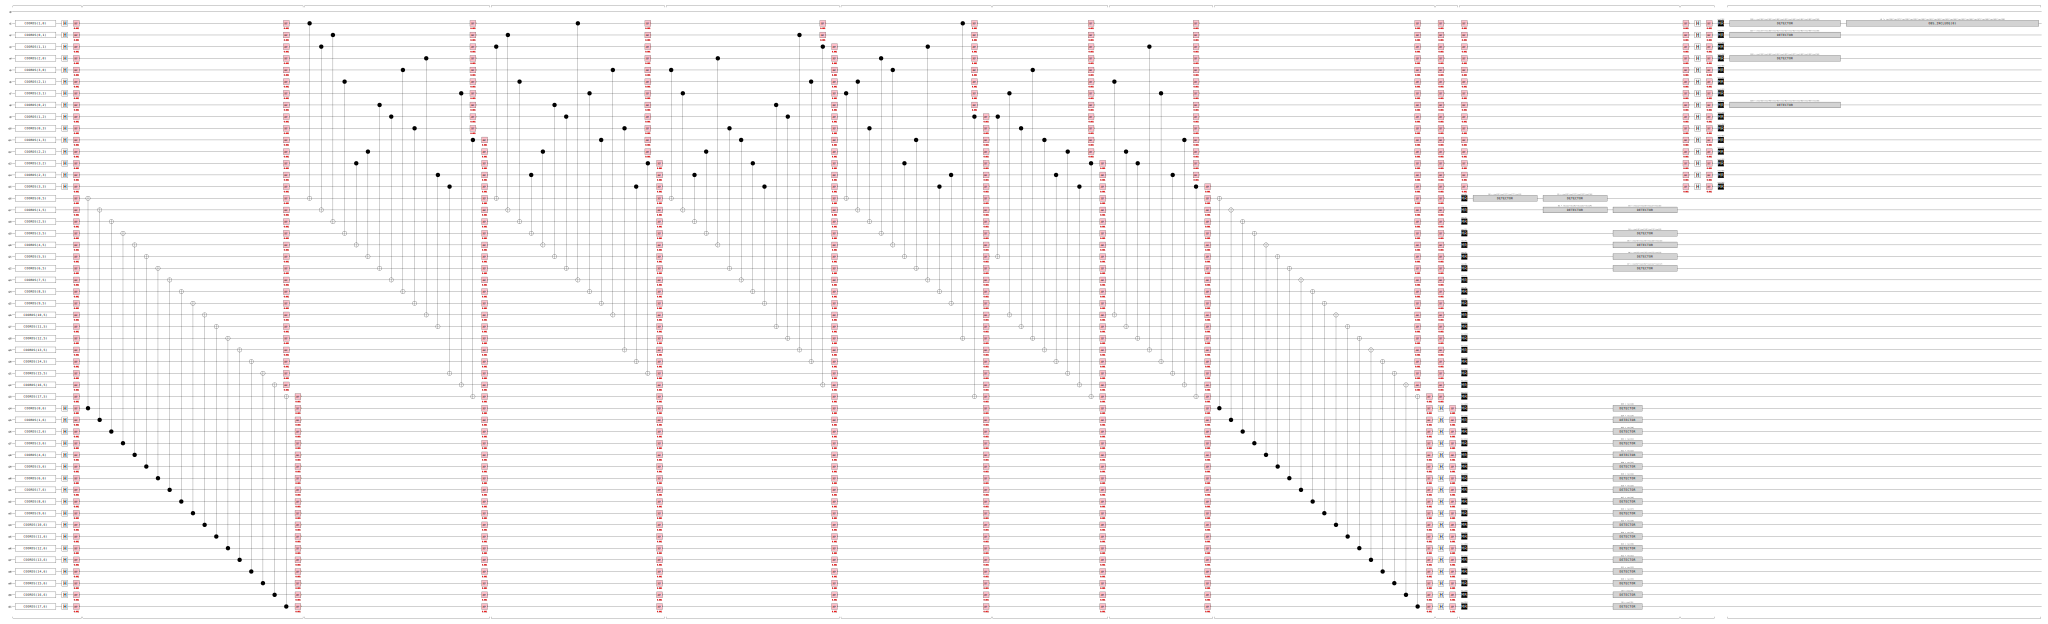

In [31]:
def qrm_circuit_flag(error_rate=0.01):
    """
    Returns a QRM circuit with depolarizing noise applied.
    The error rate can be adjusted.
    """
    circuit = stim.Circuit()
    for i in range(1, 16):
        circuit.append("QUBIT_COORDS", [i], [get_bit(i,0) + 2 * get_bit(i,2), get_bit(i,1) + 2 * get_bit(i,3)])
    for j in range(16,34):
        circuit.append("QUBIT_COORDS", [j], [j - 16, 5])
    for j in range(34,52):
        circuit.append("QUBIT_COORDS", [j], [j - 34, 6])

    # initialize data qubits, ancilla qubits and flags
    circuit.append('H', list(range(1, 16)))
    circuit.append('H', list(range(34, 52)))
    circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
    circuit.append('TICK')

    # one round of stabilizer measurements
    for i in range(6):
        if i == 0:
            for j in range(18):
                circuit.append('CNOT', [34 + j, 16 + j])
            circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
            circuit.append('TICK')
        for j in range(18):
            qubit = QRM_Z_CHECKS[j][i]
            if qubit != 0:
                circuit.append('CNOT', [qubit, 16 + j])
        circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
        circuit.append('TICK')
        if i == 5:
            for j in range(18):
                circuit.append('CNOT', [34 + j, 16 + j])
            circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
            circuit.append('TICK')
            circuit.append('H', list(range(34,52)))
            circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
            circuit.append('TICK')
    circuit.append('MR', list(range(16, 52)))
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])


    # metachecks
    for mc in QRM_META_CHECKS:
        mc = [c - 37 for c in mc]
        circuit.append('DETECTOR', [stim.target_rec(mc[0]),stim.target_rec(mc[1]),stim.target_rec(mc[2]),stim.target_rec(mc[3])])

    # check flags
    for j in range(18):
        circuit.append('DETECTOR', [stim.target_rec(-j-1)]) 
    circuit.append('TICK')

    # final measurements
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])
    circuit.append('H', list(range(1, 16)))
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])
    circuit.append('TICK')

    circuit.append('MR', list(range(1, 16)))
    circuit.append('TICK')
    
    # readout checks
    for stabilizer in QRM_X_CHECKS:
        circuit.append('DETECTOR', [stim.target_rec(i - 16) for i in stabilizer])
    
    # readout logical X
    circuit.append('OBSERVABLE_INCLUDE', [stim.target_rec(i - 15) for i in range(15)], 0)

    return circuit

circuit = qrm_circuit_flag(error_rate=0.001)
# circuit.without_noise().diagram('timeline-3d')
# circuit.without_noise().diagram('timeslice-svg')
circuit.diagram('timeline-svg')

[-6.457775907873672, -6.059260945398487, -5.4124531671153475, -4.781324804480712, -4.321818704082481, -3.8375096761423593, -3.361572351709554, -2.829025197269877, -2.300083306593107, -1.812636703778707] [0.8607899, 0.802341, 0.7237877, 0.6225325, 0.4993392, 0.3611345, 0.2250894, 0.11299, 0.0416092, 0.0098867]


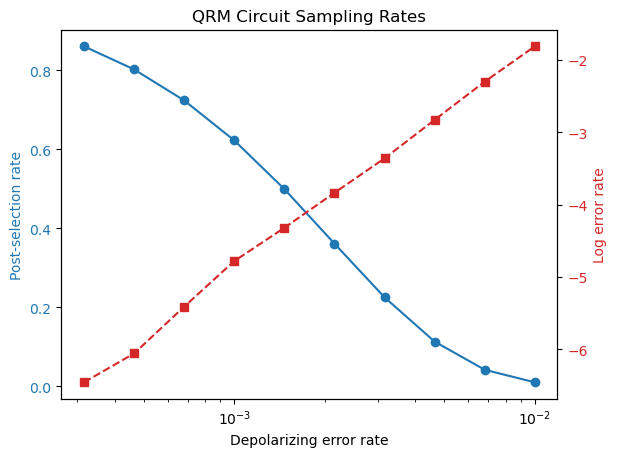

In [30]:
import matplotlib.pyplot as plt

def qrm_sampling(error_rate=0.01, N=200000):
    """
    Samples the QRM circuit with depolarizing noise.
    The error rate can be adjusted.
    Returns the post-selection rate and the error rate.
    """
    circuit = qrm_circuit_flag(error_rate)
    
    sampler = circuit.compile_sampler()
    converter = circuit.compile_m2d_converter()
    detector_samples = converter.convert(measurements=sampler.sample(N), append_observables=True)
    
    N_true = (detector_samples.sum(axis=1) == 0).sum()
    N_post = (detector_samples[:, :-1].sum(axis=1) == 0).sum()
    
    post_selection_rate = N_post / N
    log_error_rate = np.log10(1 - N_true / N_post)
    
    return post_selection_rate, log_error_rate

error_rates = [10**(x) for x in np.linspace(-3.5, -2, 10)]
post_selection_rates = []
log_error_rates = []
for error_rate in error_rates:
    post_selection_rate, log_error_rate = qrm_sampling(error_rate, N=int(1e7))
    post_selection_rates.append(post_selection_rate)
    log_error_rates.append(log_error_rate)

print(log_error_rates, post_selection_rates)
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Depolarizing error rate')
ax1.set_ylabel('Post-selection rate', color=color)
ax1.plot(error_rates, post_selection_rates, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Log error rate', color=color)
ax2.plot(error_rates, log_error_rates, 's--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('QRM Circuit Sampling Rates')
plt.show()

Actually, the simulation above exaggerates the idling error.

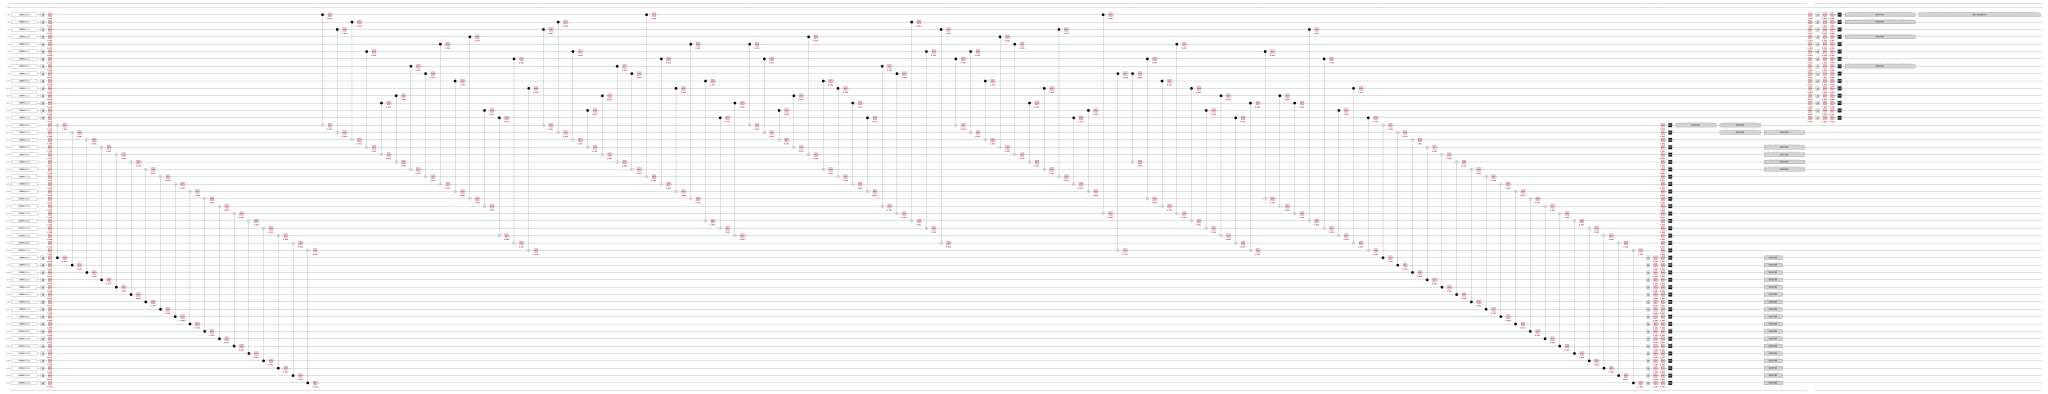

In [3]:
def qrm_circuit_flag(error_rate=0.01):
    """
    Returns a QRM circuit with depolarizing noise applied.
    The error rate can be adjusted.
    """
    circuit = stim.Circuit()
    for i in range(1, 16):
        circuit.append("QUBIT_COORDS", [i], [get_bit(i,0) + 2 * get_bit(i,2), get_bit(i,1) + 2 * get_bit(i,3)])
    for j in range(16,34):
        circuit.append("QUBIT_COORDS", [j], [j - 16, 5])
    for j in range(34,52):
        circuit.append("QUBIT_COORDS", [j], [j - 34, 6])

    # initialize data qubits, ancilla qubits and flags
    circuit.append('H', list(range(1, 16)))
    circuit.append('H', list(range(34, 52)))
    circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
    circuit.append('TICK')

    # one round of stabilizer measurements
    for i in range(6):
        if i == 0:
            for j in range(18):
                circuit.append('CNOT', [34 + j, 16 + j])
                circuit.append("DEPOLARIZE1", [34 + j, 16 + j], [error_rate])
            circuit.append('TICK')
        for j in range(18):
            qubit = QRM_Z_CHECKS[j][i]
            if qubit != 0:
                circuit.append('CNOT', [qubit, 16 + j])
                circuit.append("DEPOLARIZE1", [qubit, 16 + j], [error_rate])
        circuit.append('TICK')
        if i == 5:
            for j in range(18):
                circuit.append('CNOT', [34 + j, 16 + j])
                circuit.append("DEPOLARIZE1", [34 + j, 16 + j], [error_rate])
            circuit.append('TICK')
            circuit.append('H', list(range(34,52)))
            circuit.append("DEPOLARIZE1", list(range(34,52)), [error_rate])
            circuit.append('TICK')
    circuit.append('X_ERROR', list(range(16, 52)), [error_rate])
    circuit.append('MR', list(range(16, 52)))


    # metachecks
    for mc in QRM_META_CHECKS:
        mc = [c - 37 for c in mc]
        circuit.append('DETECTOR', [stim.target_rec(mc[0]),stim.target_rec(mc[1]),stim.target_rec(mc[2]),stim.target_rec(mc[3])])

    # check flags
    for j in range(18):
        circuit.append('DETECTOR', [stim.target_rec(-j-1)]) 
    circuit.append('TICK')

    # one layer of gate
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])
    circuit.append('TICK')

    # final measurements
    circuit.append('H', list(range(1, 16)))
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])
    circuit.append('TICK')

    circuit.append('X_ERROR', list(range(1, 16)), [error_rate])
    circuit.append('MR', list(range(1, 16)))
    circuit.append('TICK')
    
    # readout checks
    for stabilizer in QRM_X_CHECKS:
        circuit.append('DETECTOR', [stim.target_rec(i - 16) for i in stabilizer])
    
    # readout logical X
    circuit.append('OBSERVABLE_INCLUDE', [stim.target_rec(i - 15) for i in range(15)], 0)

    return circuit

circuit = qrm_circuit_flag(error_rate=0.001)
# circuit.without_noise().diagram('timeline-3d')
# circuit.without_noise().diagram('timeslice-svg')
circuit.diagram('timeline-svg')

In [4]:
circuit.diagram('matchgraph-3d')

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":3,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":4,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":5,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":6,"byteOffset":0,"componentType":5126,"count":736,"max":[21,24.5079135894775,-1],"min":[-10,-9.86393928527832,-1],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":7,"byteOffset":0,"componentType":5126,"count":496,"max":[28.592565536499,15,-1],"min":[3,-7.68221282958984,-1],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":1,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":2,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":3,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":4,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":5,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":6,"byteLength":8832,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":7,"byteLength":5952,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":8832,"name":"buf_scattered_lines","uri":"data:application/octet-stream;base64,AAAAAAAAAAAAAIC/TfbywNRA0MAAAIC/AAAAAAAAAAAAAIC/AABAQAAAAAAAAIC/AAAAAAAAAAAAAIC/AABAQAAAAAAAAIC/AAAAAAAAQEAAAIC/AAAAAAAAwEAAAIC/AAAAAAAAAAAAAIC/AABAQAAAAAAAAIC/AAAAAAAAQEAAAIC/AAAAAAAAwEAAAIC/AAAQQQAAAAAAAIC/AADAQAAAQEAAAIC/AAAAAAAAAAAAAIC/AABAQAAAAAAAAIC/AAAAAAAAQEAAAIC/AAAAAAAAwEAAAIC/AAAQQ

/var/folders/xh/4050w8c53s1g7wzh681w8sr40000gn/T/ipykernel_2008/3795756206.py:19: RuntimeWarning: divide by zero encountered in log10
  log_error_rate = np.log10(1 - N_true / N_post)


[-inf, -6.237330258084374, -5.6055622059593535, -5.561813448199352, -4.844692164218724, -4.324961409918886, -3.818077656970419, -3.337100630197131, -2.8294973741016665, -2.3502588057374503] [0.9048495, 0.8635754, 0.8064774, 0.7291946, 0.6294115, 0.5071923, 0.3696698, 0.2325329, 0.1182452, 0.0442859]


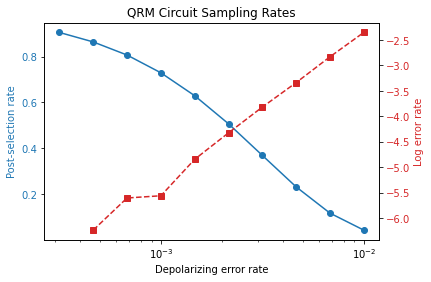

In [5]:
import matplotlib.pyplot as plt

def qrm_sampling(error_rate=0.01, N=200000):
    """
    Samples the QRM circuit with depolarizing noise.
    The error rate can be adjusted.
    Returns the post-selection rate and the error rate.
    """
    circuit = qrm_circuit_flag(error_rate)
    
    sampler = circuit.compile_sampler()
    converter = circuit.compile_m2d_converter()
    detector_samples = converter.convert(measurements=sampler.sample(N), append_observables=True)
    
    N_true = (detector_samples.sum(axis=1) == 0).sum()
    N_post = (detector_samples[:, :-1].sum(axis=1) == 0).sum()
    
    post_selection_rate = N_post / N
    log_error_rate = np.log10(1 - N_true / N_post)
    
    return post_selection_rate, log_error_rate

error_rates = [10**(x) for x in np.linspace(-3.5, -2, 10)]
post_selection_rates = []
log_error_rates = []
for error_rate in error_rates:
    post_selection_rate, log_error_rate = qrm_sampling(error_rate, N=int(1e7))
    post_selection_rates.append(post_selection_rate)
    log_error_rates.append(log_error_rate)

print(log_error_rates, post_selection_rates)
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Depolarizing error rate')
ax1.set_ylabel('Post-selection rate', color=color)
ax1.plot(error_rates, post_selection_rates, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Log error rate', color=color)
ax2.plot(error_rates, log_error_rates, 's--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('QRM Circuit Sampling Rates')
plt.show()

In [7]:
import numpy as np
from typing import Iterable

def make_postselection_mask(num_detectors: int, indices: Iterable[int]) -> np.ndarray:
    """
    Build a bit-packed uint8 mask for Sinter's postselection_mask.

    - Bit i corresponds to detector i (LSB-first within each byte).
    - Set bit i to 1 to postselect that detector (discard shots where it fires).

    Args:
        num_detectors: Total number of detectors in the DEM/circuit.
        indices: Iterable of detector indices to postselect on (0-based).

    Returns:
        np.ndarray of shape (ceil(num_detectors/8),) and dtype=np.uint8.
    """
    if num_detectors < 0:
        raise ValueError("num_detectors must be non-negative")
    nbytes = (num_detectors + 7) // 8
    mask = np.zeros(nbytes, dtype=np.uint8)

    idx = np.fromiter(indices, dtype=np.int64, count=-1)
    if idx.size == 0:
        return mask  # nothing to set

    if (idx < 0).any() or (idx >= num_detectors).any():
        bad = idx[(idx < 0) | (idx >= num_detectors)]
        raise ValueError(f"indices out of range: {bad.tolist()} for num_detectors={num_detectors}")

    byte_idx = (idx >> 3).astype(np.int64)
    bit_pos = (idx & 7).astype(np.uint8)
    vals = (1 << bit_pos).astype(np.uint8)

    # In-place OR accumulation handles duplicates correctly.
    np.bitwise_or.at(mask, byte_idx, vals)
    return mask

In [8]:
import sinter
from typing import List
from null_decoder import NullDecoder


tasks = [
    sinter.Task(
        circuit = qrm_circuit_flag(noise),
        postselection_mask = make_postselection_mask(30, list(range(30))),
        json_metadata={'noise': noise}
    )
    for noise in [10**(x) for x in np.linspace(-3.5, -2, 10)]
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=16,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=10_000_000,
    max_errors=5000,
)

RuntimeError: Worker failed: traceback=Traceback (most recent call last):
  File "/Users/wangyifei/miniforge3/lib/python3.9/site-packages/sinter/_collection/_collection_worker_state.py", line 246, in run_message_loop
    did_some_work = self.do_some_work()
  File "/Users/wangyifei/miniforge3/lib/python3.9/site-packages/sinter/_collection/_collection_worker_state.py", line 217, in do_some_work
    some_work_done = self.compiled_sampler.sample(self.current_task_shots_left)
  File "/Users/wangyifei/miniforge3/lib/python3.9/site-packages/sinter/_collection/_sampler_ramp_throttled.py", line 51, in sample
    result = self.sub_sampler.sample(actual_shots)
  File "/Users/wangyifei/miniforge3/lib/python3.9/site-packages/sinter/_decoding/_stim_then_decode_sampler.py", line 201, in sample
    raise ValueError("predictions.shape[0] != num_shots")
ValueError: predictions.shape[0] != num_shots


In [ ]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['noise'],
)
# ax.set_ylim(1e-6, 5e-1)
# ax.set_xlim(5e-4, 1e-2)
ax.loglog()
ax.set_title("QRM Simulation")
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger